# Customizing visualizations

## Setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

fb = pd.read_csv(
    'data/fb_stock_prices.csv', index_col='Date', parse_dates=True
)
fb2 = pd.read_csv(
    'data/fb_2.csv', index_col='Date', parse_dates=True
)
fb_full = fb.append(fb2)

quakes = pd.read_csv('data/earthquakes.csv')

## Adding reference lines
### Horizontal reference lines
`axhline()` adds horizontal lines. We simply specify the y value to draw the horizontal line at with the `y` parameter. Optionally, we can provide:
- `label` for a string that will show up in the legend
- `color` for the color of the reference line
- `linestyle` for the type of line to draw

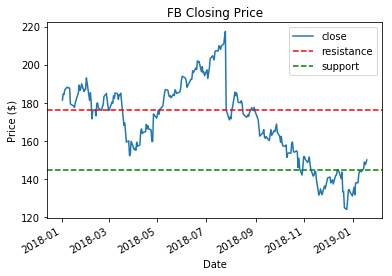

In [2]:
fb_full.Close.plot(title='FB Closing Price', label='close')
plt.axhline(y=176.26, label='resistance', color='r', linestyle='--')
plt.axhline(y=144.56, label='support', color='g', linestyle='--')
plt.ylabel('Price ($)')
plt.legend()

### Vertical reference lines
For vertical lines, we use `axvline()` and provide the `x` parameter for where to draw it. The `std_from_mean_kde()` function draws vertical reference lines using `axvline()` at each standard deviation from the mean (1-3) and the mean. Note, we need to import it from the `std_from_mean_kde.py` module, before we can use it.

Text(0.5, 0, 'mb earthquake magnitude')

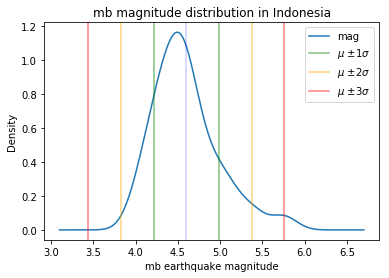

In [3]:
from std_from_mean_kde import std_from_mean_kde

ax = std_from_mean_kde(
    quakes.query(
        'magType == "mb" and parsed_place == "Indonesia"'
    ).mag
)
ax.set_title('mb magnitude distribution in Indonesia')
ax.set_xlabel('mb earthquake magnitude')

### Lines with Slope
For a straight line, we just need to provide 2 endpoints which will be connected to form a line.

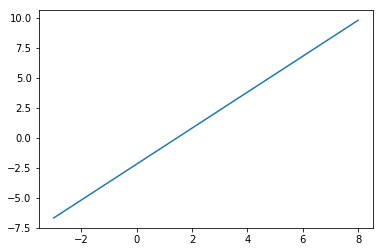

In [4]:
x = np.array([-3, 8])
m, b = 1.5, -2.2
y = m*x + b
plt.plot(x, y)

## Shading regions
We can use `axhspan()` and `axvspan()` to shade horizontal and vertical regions, respectively.

Text(0, 0.5, 'Price ($)')

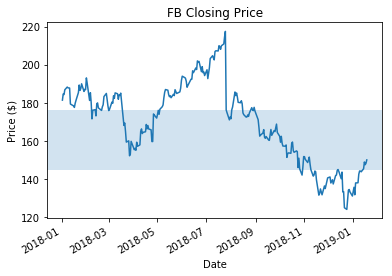

In [5]:
ax = fb_full.Close.plot(title='FB Closing Price')
ax.axhspan(144.56, 176.26, alpha=0.2)
plt.ylabel('Price ($)')

Rather than filling in a rectangular region, we can fill between two curves using `plt.fill_between()`:

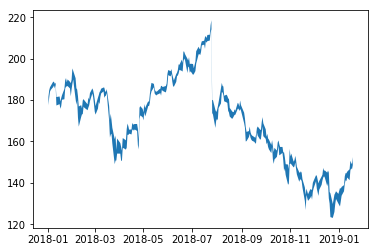

In [6]:
plt.fill_between(fb_full.index, fb_full.High, fb_full.Low)

## Annotations
The `plt.annotate()` function can be used to add annotation to plots. Some important arguments:
- `xy`: a tuple of the coordinates to annotate
- `xytext`: a tuple of coordinates of where to place the annotation text
- `arrowprops`: a dictionary of how to draw the arrow from the text of the annotation to the point being annotated

Text(0, 0.5, 'Price ($)')

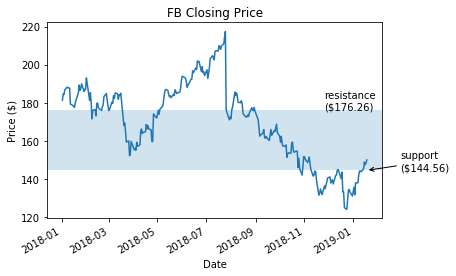

In [7]:
resistance, support = 176.26, 144.56
ax = fb_full.Close.plot(title='FB Closing Price')
ax.axhspan(support, resistance, alpha=0.2)
plt.annotate(
    f'support\n(${support})',
    xy=('2019-01-18', support),
    xytext=('2019-03-01', support),
    arrowprops={'arrowstyle' : '->'}
)
plt.annotate(
    f'resistance\n(${resistance})',
    xy=('2018-11-25', resistance)
)
plt.ylabel('Price ($)')

We have many options for the arrow:

Text(2018-08-14, 194.695, '-19.59%')

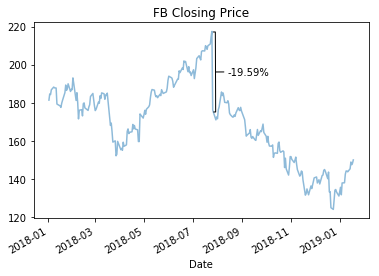

In [8]:
close_price = fb_full.loc['2018-07-25', 'Close']
open_price = fb_full.loc['2018-07-26', 'Open']
pct_drop = (open_price - close_price)/close_price
fb_full.Close.plot(title='FB Closing Price', alpha=0.5)
plt.annotate(
    f'{pct_drop:.2%}',
    xy=('2018-07-27', (open_price + close_price)/2),
    xytext=('2018-08-14', (open_price + close_price)/2 - 1.5),
    arrowprops=dict(arrowstyle='-[,widthB=4.0,lengthB=0.2')
)

## Colors
We can pass colors to the `color` argument of the `plot()` method. This can be a color name, a hex code, or RGB values.

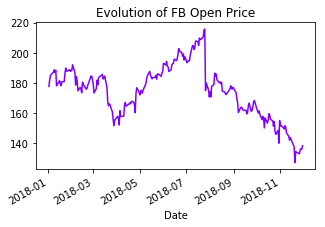

In [9]:
fb.plot(
    kind='line',
    y='Open',
    figsize=(5, 3),
    color='#8000FF',
    legend=False,
    title='Evolution of FB Open Price'
)

RGB values must be given as decimals:

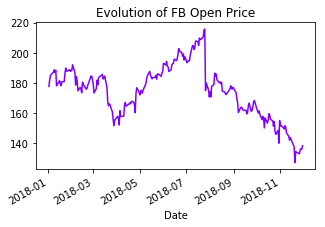

In [10]:
fb.plot(
    kind='line',
    y='Open',
    figsize=(5, 3),
    color=(128/255, 0, 1),
    legend=False,
    title='Evolution of FB Open Price'
)

### Colormaps
#### Finding available colormaps

In [11]:
from matplotlib import cm
cm.datad.keys()

dict_keys(['Blues', 'BrBG', 'BuGn', 'BuPu', 'CMRmap', 'GnBu', 'Greens', 'Greys', 'OrRd', 'Oranges', 'PRGn', 'PiYG', 'PuBu', 'PuBuGn', 'PuOr', 'PuRd', 'Purples', 'RdBu', 'RdGy', 'RdPu', 'RdYlBu', 'RdYlGn', 'Reds', 'Spectral', 'Wistia', 'YlGn', 'YlGnBu', 'YlOrBr', 'YlOrRd', 'afmhot', 'autumn', 'binary', 'bone', 'brg', 'bwr', 'cool', 'coolwarm', 'copper', 'cubehelix', 'flag', 'gist_earth', 'gist_gray', 'gist_heat', 'gist_ncar', 'gist_rainbow', 'gist_stern', 'gist_yarg', 'gnuplot', 'gnuplot2', 'gray', 'hot', 'hsv', 'jet', 'nipy_spectral', 'ocean', 'pink', 'prism', 'rainbow', 'seismic', 'spring', 'summer', 'terrain', 'winter', 'Accent', 'Dark2', 'Paired', 'Pastel1', 'Pastel2', 'Set1', 'Set2', 'Set3', 'tab10', 'tab20', 'tab20b', 'tab20c', 'Blues_r', 'BrBG_r', 'BuGn_r', 'BuPu_r', 'CMRmap_r', 'GnBu_r', 'Greens_r', 'Greys_r', 'OrRd_r', 'Oranges_r', 'PRGn_r', 'PiYG_r', 'PuBu_r', 'PuBuGn_r', 'PuOr_r', 'PuRd_r', 'Purples_r', 'RdBu_r', 'RdGy_r', 'RdPu_r', 'RdYlBu_r', 'RdYlGn_r', 'Reds_r', 'Spectral

We can pass a colormap to the `colormap` argument:

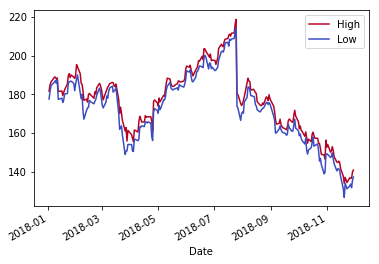

In [12]:
fb.iloc[:,1:3].plot(colormap=cm.coolwarm_r)

We can also grab colors out of a colormap, which is a callable:

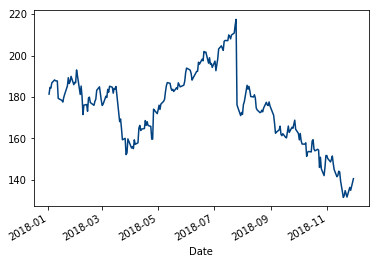

In [13]:
fb.Close.plot(color=cm.get_cmap('ocean')(.5))

#### Making colormaps
In order to make colormaps, we need some utility functions which can be found in the `color_utils.py` module. We will need to be able to convert hex colors to RGBA decimals, blend colors to build a colormap, and draw the colormap.

In [14]:
import color_utils

##### Sequential two-color colormaps
Blend from the first color to the second:

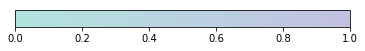

In [15]:
my_edge_colors = ['#B2E4DF', '#C2C1E1']
rgbs = color_utils.hex_to_rgb_color_list(my_edge_colors)
my_cmap = color_utils.two_color_sequential_cmap(rgbs)
color_utils.draw_cmap(my_cmap)

##### Blended colormaps
Use `blended_cmap()` to blend any number of colors:

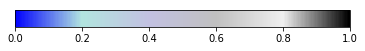

In [16]:
my_colors = [
    '#00F', '#B2E4DF', '#C2C1E1', 'C0C0C0', 'EEE', '000000'
]
rgbs = color_utils.hex_to_rgb_color_list(my_colors)
my_cmap = color_utils.blended_cmap(rgbs)
color_utils.draw_cmap(my_cmap)

#### Cycling through colors
We can use itertools to cycle through colors:

In [17]:
import itertools

colors = itertools.cycle(['#ffffff', '#f0f0f0', '#000000'])
colors

In [18]:
next(colors)

'#ffffff'

Or we can work with a `ListedColormap` from matplotlib:

In [19]:
from matplotlib.colors import ListedColormap
red_black = ListedColormap(['red', 'black'], N=2000)
[red_black(i) for i in range(3)]

[(1.0, 0.0, 0.0, 1.0), (0.0, 0.0, 0.0, 1.0), (1.0, 0.0, 0.0, 1.0)]

We may also consider using a generator:

In [20]:
def color_generator():
    for year in range(1992, 200019): # integers in [1992, 200019)
        if year % 100 == 0 and year % 400 != 0:
            # special case
            color = '#f0f0f0'
        elif year % 4 == 0:
            # leap year
            color = '#000000'
        else:
            color = '#ffffff'
        yield color
    
year_colors = color_generator()
year_colors

<generator object color_generator at 0x1E7948F0>

In [21]:
next(year_colors)

'#000000'

We can also make a generator with a generator expression:

In [22]:
year_colors = (
    '#ffffff' \
    if (not year % 100 and year % 400) or year % 4 \
    else '#000000' for year in range(1992, 200019)
)
year_colors

<generator object <genexpr> at 0x1E794BF0>

In [23]:
next(year_colors)

'#000000'